<a href="https://colab.research.google.com/github/guntsvzz/CP_Project/blob/main/EEG_EmotionClassification_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

     |████████████████████████████████| 7.5 MB 25.2 MB/s 


In [ ]:
!git clone https://github.com/chaklam-silpasuwanchai/EEG-Emotion-Recognition.git
import sys
sys.path.append('/content/EEG-Emotion-Recognition/projects')
sys.path.append('/content/EEG-Emotion-Recognition/projects/components')

Cloning into 'EEG-Emotion-Recognition'...
remote: Enumerating objects: 4594, done.
remote: Counting objects: 100% (740/740), done.
remote: Compressing objects: 100% (283/283), done.
remote: Total 4594 (delta 450), reused 736 (delta 449), pack-reused 3854
Receiving objects: 100% (4594/4594), 324.69 MiB | 32.28 MiB/s, done.
Resolving deltas: 100% (454/454), done.
Checking out files: 100% (2627/2627), done.


In [ ]:
!gdown --id 1qaf8xVdOtQm19CTtcMznJ-ehnQMcAWos
!unzip /content/experiment1.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1qaf8xVdOtQm19CTtcMznJ-ehnQMcAWos
To: /content/experiment1.zip
100% 27.2M/27.2M [00:02<00:00, 12.3MB/s]
Archive:  /content/experiment1.zip
   creating: experiment1/
  inflating: __MACOSX/._experiment1  
  inflating: experiment1/feemsad__2022-03-16-02.35.03.csv  
  inflating: __MACOSX/experiment1/._feemsad__2022-03-16-02.35.03.csv  
  inflating: experiment1/beausad__2022-03-16-03.39.07.csv  
  inflating: __MACOSX/experiment1/._beausad__2022-03-16-03.39.07.csv  
  inflating: experiment1/sayakasad__2022-03-16-02.55.51.csv  
  inflating: __MACOSX/experiment1/._sayakasad__2022-03-16-02.55.51.csv  
  inflating: experiment1/feemhappy__2022-03-16-02.22.45.csv  
  inflating: __MACOSX/experiment1/._feemhappy__2022-03-16-02.2

In [ ]:
# from dataset import Dataset
# from helper import getLoaders, count_parameters, plot_performance
from helper import initialize_weights
from train import train, evaluate

In [ ]:
import os
from glob import glob

import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F


from torch.utils.data import DataLoader, Dataset

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
test_path = '/content/experiment1/beauhappy__2022-03-16-03.28.47.csv'

def extract_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    data = df.iloc[:, 1:-1].values.T
    duration = df['timestamps'].max() - df['timestamps'].min()
    label = 0 if 'happy' in csv_path else 1

    return {'data':data,
            'label':label,
            'duration':duration}

In [ ]:
test_df = pd.read_csv(test_path)

In [ ]:
print(list(test_df.columns[1:-1]))

['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2']


In [ ]:
MAIN_DIR = '/content/experiment1'

SR = 125 #Signal - 125 HZ
ACTUAL_TIME = 5 * 60 # 5 mins

In [ ]:
data_arr = []
label_arr = []
name_arr = []

for csv_path in glob(os.path.join(MAIN_DIR, '*.csv')):
    name_arr.append( csv_path.split('/')[3].split('_')[0] )
    extracted = extract_from_csv(csv_path)
    data = extracted['data']
    label = extracted['label']
    duration = extracted['duration']
    
    data = data[:, :SR*ACTUAL_TIME]

    data_arr.append(data)
    label_arr.append(label)

data_arr = np.array(data_arr)
label_arr = np.array(label_arr)

In [ ]:
data_arr.shape, label_arr.shape

((8, 16, 37500), (8,))

In [ ]:
label_arr

array([1, 1, 0, 0, 0, 1, 1, 0])

In [ ]:
train_data_arr = data_arr[:-2]
train_label_arr = label_arr[:-2]

test_data_arr = data_arr[-2:]
test_label_arr = label_arr[-2:]

In [ ]:
data_arr.shape

(8, 16, 37500)

In [ ]:
class EEGDataset(Dataset):
    
    def __init__(self, data_arr, label_arr):
                
        self.data = data_arr   #shape: (n_samples, 16, 45000) 
        
        shape = self.data.shape
        
        #perform segmentation=====
        segments = 60 # 2 sec per segment
        
        self.data = self.data.reshape(shape[0], shape[1], int(shape[2]/segments), segments)
        #data shape: (1280, 32, 672, 12)

        self.data = self.data.transpose(0, 3, 1, 2)
        #data shape: (1280, 12, 32, 672)

        self.data = self.data.reshape(shape[0] * segments, shape[1], -1)
        #data shape: (1280*12, 32, 672)
        #==========================
        
        self.label = label_arr[:, np.newaxis] #(8, 1)  ==> 8 samples, 
        self.label = np.repeat(self.label, segments)[:, np.newaxis]  #the dimension 1 is lost after repeat, so need to unsqueeze (1280*12, 1)
        
        # del temp, all_data, all_label

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        single_data  = self.data[idx]
        # single_label = (self.label[idx] > 5).astype(float)   #convert the scale to either 0 or 1 (to classification problem)
        single_label = self.label[idx].astype(float)

        batch = {
            'data': torch.Tensor(single_data),
            'label': torch.Tensor(single_label)
        }
        
        # return batch
        return batch['data'], batch['label']


In [ ]:
train_dataset = EEGDataset(train_data_arr, train_label_arr)
val_dataset = EEGDataset(test_data_arr, test_label_arr)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)
# test_loader = DataLoader(dataset=test_set, batch_size=16)


## Extract Feature

In [ ]:
import mne
mne.sys_info()


Platform:         Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
Python:           3.7.13 (default, Apr 24 2022, 01:04:09)  [GCC 7.5.0]
Executable:       /usr/bin/python3
CPU:              x86_64: 2 cores
Memory:           12.7 GB

mne:              1.0.2
numpy:            1.21.6 {blas=openblas, lapack=openblas}
scipy:            1.4.1
matplotlib:       3.2.2 {backend=module://ipykernel.pylab.backend_inline}

sklearn:          1.0.2
numba:            0.51.2
nibabel:          3.0.2
nilearn:          Not found
dipy:             Not found
cupy:             Not found
pandas:           1.3.5
pyvista:          Not found
pyvistaqt:        Not found
ipyvtklink:       Not found
vtk:              Not found
PyQt5:            Not found
ipympl:           Not found
pooch:            v1.6.0

mne_bids:         Not found
mne_nirs:         Not found
mne_features:     Not found
mne_qt_browser:   Not found
mne_connectivity: Not found


In [ ]:
ch_names = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2']
ch_types = ['eeg'] * len(ch_names)
sfreq = 125 #Hz
# https://mne.tools/stable/generated/mne.create_info.html
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
epochs = mne.EpochsArray(data_arr[:],info)
epochs.set_montage('standard_1020')
print('----')
# You can access the original data using <>._data 
print(f"{epochs._data.shape}")
print('----')
epochs


Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
----
(8, 16, 37500)
----


Number of events,8
Events,1: 8
Time range,0.000 – 299.992 sec
Baseline,off


In [ ]:
# Thier shape is different. 
print(type(epochs.__getitem__(0)),  epochs.__getitem__(0)._data.shape )

for evoked in epochs.iter_evoked():
    print(type(evoked), evoked.get_data().shape)
    break

# There attribute/meta is different
print(evoked)
epochs.__getitem__(1)


<class 'mne.epochs.EpochsArray'> (1, 16, 37500)
<class 'mne.evoked.EvokedArray'> (16, 37500)
<Evoked | '1' (average, N=1), 0 – 299.99 sec, baseline off, 16 ch, ~4.6 MB>


Number of events,1
Events,1: 1
Time range,0.000 – 299.992 sec
Baseline,off


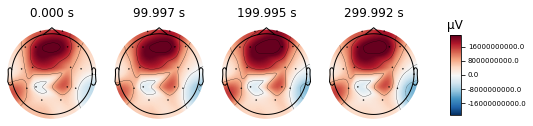

-----
Creating RawArray with float64 data, n_channels=16, n_times=37500
    Range : 0 ... 37499 =      0.000 ...   299.992 secs
Ready.
Effective window size : 16.384 (s)


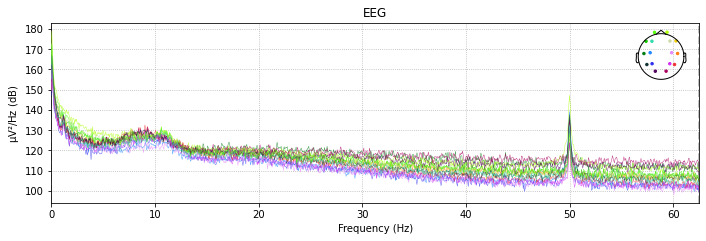

-----
    Using multitaper spectrum estimation with 7 DPSS windows


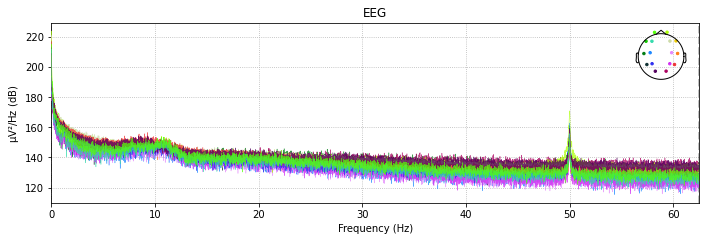

-----
    Using multitaper spectrum estimation with 7 DPSS windows


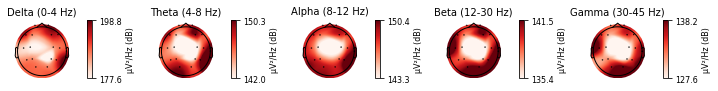

In [ ]:
for evoked in epochs.iter_evoked():
    # Plot a topomap from two different method
    evoked.plot_topomap()
    print('-----')
    # Here we plot Power Spectral Density using two different method
    raw = mne.io.RawArray(evoked.get_data(),info=info)
    raw.set_montage('standard_1020')
    raw.plot_psd()
    print('-----')
    epochs.__getitem__(0).plot_psd()
    print('-----')
    epochs.__getitem__(0).plot_psd_topomap()
    break


In [ ]:
epoch = epochs.__getitem__(0)
psds, freqs = mne.time_frequency.psd_welch(epoch) # feature extraction
# print(psds.shape, freqs.shape) => (1, 32, 129) (129,)

print(freqs)


Effective window size : 2.048 (s)
[ 0.          0.48828125  0.9765625   1.46484375  1.953125    2.44140625
  2.9296875   3.41796875  3.90625     4.39453125  4.8828125   5.37109375
  5.859375    6.34765625  6.8359375   7.32421875  7.8125      8.30078125
  8.7890625   9.27734375  9.765625   10.25390625 10.7421875  11.23046875
 11.71875    12.20703125 12.6953125  13.18359375 13.671875   14.16015625
 14.6484375  15.13671875 15.625      16.11328125 16.6015625  17.08984375
 17.578125   18.06640625 18.5546875  19.04296875 19.53125    20.01953125
 20.5078125  20.99609375 21.484375   21.97265625 22.4609375  22.94921875
 23.4375     23.92578125 24.4140625  24.90234375 25.390625   25.87890625
 26.3671875  26.85546875 27.34375    27.83203125 28.3203125  28.80859375
 29.296875   29.78515625 30.2734375  30.76171875 31.25       31.73828125
 32.2265625  32.71484375 33.203125   33.69140625 34.1796875  34.66796875
 35.15625    35.64453125 36.1328125  36.62109375 37.109375   37.59765625
 38.0859375  38.5

In [ ]:
epoch = epochs.__getitem__(0)
psds, freqs = mne.time_frequency.psd_welch(epoch, n_fft=125)
# print(psds.shape, freqs.shape) => (1, 32, 65) (65,)

print(freqs)


Effective window size : 1.000 (s)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62.]


In [ ]:
# Note that now I use `epochs`
psds, freqs = mne.time_frequency.psd_welch(epochs, n_fft=125)
psds = 10 * np.log10(psds)
print(psds.shape, freqs.shape)


Effective window size : 1.000 (s)
(8, 16, 63) (63,)


In [ ]:
import pickle

X_65 = psds.mean(axis=1)
print(X_65.shape)

# I am going to save this because it takes long time to get this data.
with open(f'X_65.pickle', 'wb') as handle:
    pickle.dump(X_65, handle, protocol=pickle.HIGHEST_PROTOCOL)


(8, 63)


In [ ]:
bands = [(1,3), (4,7), (8,12), (13,30), (31,45)]

X_5 = []
for band in bands:
    # Make copy just in case. Bad habbit, 
    selected_band = X_65[:,band[0]:band[1]+1].copy()
    # Bad line of code.
    # .mean(axis=1) will extract that target band into one number
    # the shape is (n_sample,) and it won't let we .hstack. Therefore, I has to make it (n_sample, 1)
    X_5.append(np.expand_dims(selected_band.mean(axis=1), axis=1))

X_5 = np.hstack(X_5)
print(X_5.shape)

# I am going to save this because it takes long time to get this data.
with open(f'X_5.pickle', 'wb') as handle:
    pickle.dump(X_5, handle, protocol=pickle.HIGHEST_PROTOCOL)


(8, 5)


In [ ]:
y = np.array(label_arr)
print(y.shape)

# sklearn SVM accepts y array in shape of (n_samples,)
y = y.squeeze()
print(y.shape)

# Save!!!!!!!
with open(f'y_valence.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)


(8,)
(8,)


In [ ]:
X_5.shape, y.shape

((8, 5), (8,))

## Model

In [ ]:
import pickle
def load(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data

# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
# SVM has many kernels. We could use any but searching the best kernel can also be done.
def grid_search(X_ori, y_ori):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    param_grid = dict(kernel=['linear','poly','rbf', 'sigmoid'], C=[0.01, 0.1, 1, 10], gamma=[0.01, 0.1, 1, 10])
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    grid = GridSearchCV(SVC(max_iter=10000), param_grid=param_grid, cv=cv)
    grid.fit(X, y)
    return grid


In [ ]:
# I gave up. I run this for 100 minutes and it not even finish the first gridSearch
import time
start = time.time()
grid_65 = grid_search(load("X_65.pickle"), load("y_valence.pickle"))
print("Time consumed in working: ",time.time() - start)
with open(f'grid_65.pickle', 'wb') as handle:
    pickle.dump(grid_65, handle, protocol=pickle.HIGHEST_PROTOCOL)


start = time.time()
grid_5 = grid_search(load("X_5.pickle"), load("y_valence.pickle"))
print("Time consumed in working: ",time.time() - start)
with open(f'grid_5.pickle', 'wb') as handle:
    pickle.dump(grid_5, handle, protocol=pickle.HIGHEST_PROTOCOL)



Time consumed in working:  1.2431597709655762
Time consumed in working:  0.9291965961456299


In [ ]:
print(grid_65.best_params_,grid_65.best_score_)
print(grid_5.best_params_,grid_5.best_score_)


{'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'} 0.5
{'C': 1, 'gamma': 1, 'kernel': 'poly'} 0.6


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X_norm = []
for x in X_5:
  # print(x)
  selected_x = x.reshape(1,-1).copy()
  # print(selected_x)
  X_norm.append( scaler.fit_transform(selected_x.T).T )

X_norm = np.vstack(X_norm)

In [ ]:
def train_model(X_ori,y_ori, kernel='rbf', C=1, gamma='scale', cv=3, max_iter=10000, random_state=42):
    # Make a copy because I am paranoid
    X,y = X_ori.copy(), y_ori.copy()

    from sklearn.svm import SVC
    from sklearn.utils import shuffle
    from sklearn.model_selection import cross_val_score

    # 
    X_shuff,y_shuff = shuffle(X,y, random_state=random_state)
    model = SVC(kernel=kernel,C=C, gamma=gamma, max_iter=max_iter, random_state=random_state)
    cross = cross_val_score(model, X_shuff, y_shuff, cv=cv)

    model = SVC(kernel=kernel, max_iter=max_iter)
    model.fit(X_shuff, y_shuff)
    ans = model.predict(X_shuff)
    acc = sum(ans == y_shuff) / len(y_shuff)
    if(sum(ans) == 0 or sum(ans) == len(y_shuff) ): 
      print("Ding")
    # print(ans)
    return model, acc, cross


In [ ]:
# import time
# for kernel in ['linear','poly','rbf', 'sigmoid']:
#     start = time.time()
#     model, acc, cross = train_model(load("X_65.pickle"), load("y_valence.pickle"), kernel=kernel)
#     # We can save the model and reuse it later
#     print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

In [ ]:
cv = 3
random_state = 170

C = 1
max_iter = -1
gamma = 1

import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_5, y, kernel=kernel,C=C, gamma=gamma, cv=cv, max_iter=max_iter, random_state=random_state)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | {cv}-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.75 | 3-CV score=0.22222 STD=0.15713| Time spend=0.018140077590942383
	Kernel=poly| Acc=0.5 | 3-CV score=0.22222 STD=0.15713| Time spend=0.04272627830505371
	Kernel=rbf| Acc=0.5 | 3-CV score=0.27778 STD=0.20787| Time spend=0.05532193183898926
	Kernel=sigmoid| Acc=0.5 | 3-CV score=0.38889 STD=0.07857| Time spend=0.04310464859008789


In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_norm, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.03281974792480469
	Kernel=poly| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.028837919235229492
	Kernel=rbf| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.02876734733581543
	Kernel=sigmoid| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.024329185485839844


In [ ]:
model, acc, cross = train_model(X_norm, y, kernel='linear')

In [ ]:
# from sklearn.svm import SVC
for name, x,l in zip(name_arr, X_norm, y):
  # print(x,l)
  # print(X_5.shape,x.shape)# (n_samples, n_features)
  pred = model.predict(x.reshape(1,-1))
  print(l, pred, name)
  # break

1 [0] sayakasad
1 [1] feemsad
0 [0] feemhappy
0 [1] beauhappy
0 [0] dipeshhappy
1 [0] dipeshsad
1 [1] beausad
0 [0] sayakahappy


In [ ]:
for name, x in zip(name_arr,X_norm):
  print(name,x)

sayakasad [ 1.30485417  0.31717527  0.59299194 -0.66481658 -1.5502048 ]
feemsad [ 1.41444288 -0.18796262  0.82283233 -0.7187745  -1.33053808]
feemhappy [ 1.65120555 -0.23444464  0.51196829 -0.74476693 -1.18396227]
beauhappy [ 1.05610272  0.17826432  1.03598432 -0.81708943 -1.45326193]
dipeshhappy [ 1.19699402  0.76159423  0.34389076 -0.82092608 -1.48155293]
dipeshsad [ 1.35458581  0.66289409  0.20118622 -0.77470406 -1.44396206]
beausad [ 1.05607185  0.19240422  1.03047071 -0.83204555 -1.44690123]
sayakahappy [ 1.34938045  0.3797985   0.49649179 -0.71810997 -1.50756077]


In [ ]:
import matplotlib.pyplot as plt

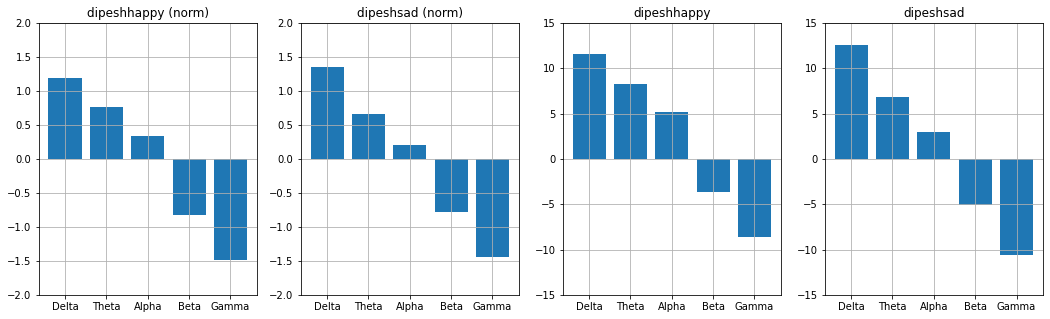

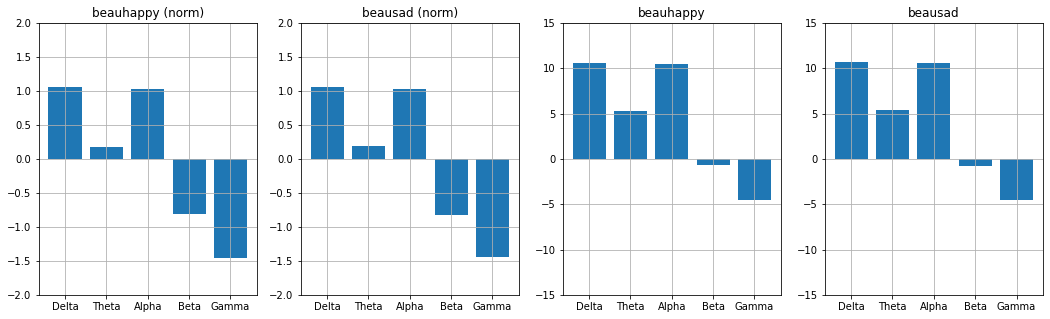

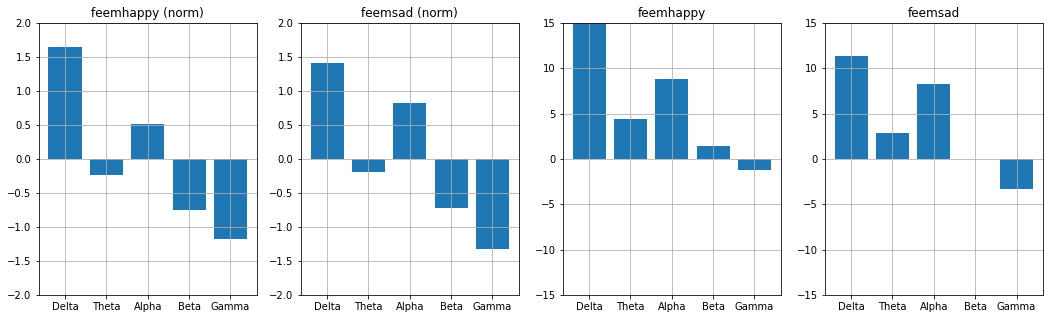

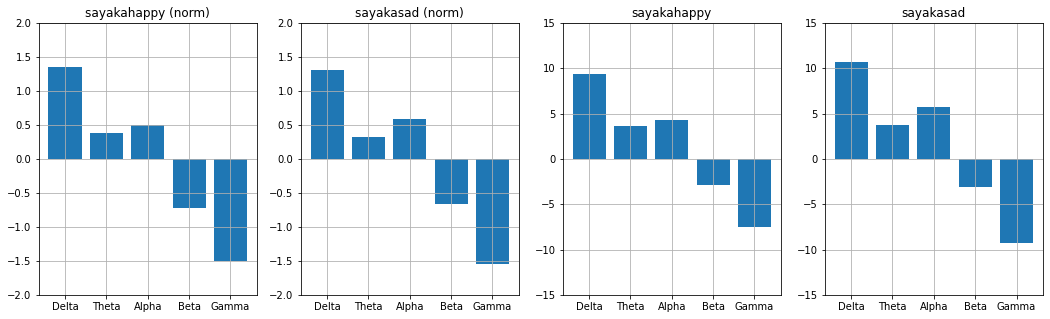

In [ ]:
names = ['dipesh', 'beau','feem', 'sayaka']

for name in names:
    fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
    lim = 2
    X_range = ['Delta','Theta','Alpha','Beta','Gamma']
    
    # happy
    title = f"{name}happy"
    x = X_norm[name_arr.index(title)]
    ax[0].bar(X_range, x)
    ax[0].set_title(title + " (norm)")
    ax[0].set_ylim(-1*lim,lim)
    ax[0].grid()
    # sad
    title = f"{name}sad"
    x = X_norm[name_arr.index(title)]
    ax[1].bar(X_range, x)
    ax[1].set_title(title + " (norm)")
    ax[1].set_ylim(-1*lim,lim)
    ax[1].grid()
    # plt.show()

    # X_5
    # happy
    lim = 15
    title = f"{name}happy"
    x = X_5[name_arr.index(title)]
    ax[2].bar(X_range, x)
    ax[2].set_title(title)
    ax[2].set_ylim(-1*lim,lim)
    ax[2].grid()
    # sad
    title = f"{name}sad"
    x = X_5[name_arr.index(title)]
    ax[3].bar(X_range, x)
    ax[3].set_title(title)
    ax[3].set_ylim(-1*lim,lim)
    ax[3].grid()
    plt.show()
    print()

In [ ]:
X_norm_ori = X_norm.copy()

In [ ]:
X_ratio = X_norm_ori.copy()
for index, x in enumerate(X_ratio):
  total = sum(abs(x))
  print(total)
  print(x, abs(x)/total)
  X_ratio[index] = abs(x)/total
print()
print(X_ratio)

4.430042756466333
[ 1.30485417  0.31717527  0.59299194 -0.66481658 -1.5502048 ] [0.29454663 0.07159643 0.13385693 0.15007001 0.34992999]
4.474550405543929
[ 1.41444288 -0.18796262  0.82283233 -0.7187745  -1.33053808] [0.31610838 0.04200704 0.18389162 0.16063614 0.29735682]
4.326347669932455
[ 1.65120555 -0.23444464  0.51196829 -0.74476693 -1.18396227] [0.3816627  0.05418997 0.1183373  0.17214681 0.27366323]
4.540702716675696
[ 1.05610272  0.17826432  1.03598432 -0.81708943 -1.45326193] [0.23258574 0.03925919 0.22815506 0.17994779 0.32005221]
4.604958008029865
[ 1.19699402  0.76159423  0.34389076 -0.82092608 -1.48155293] [0.25993592 0.16538571 0.07467837 0.17827005 0.32172995]
4.437332240392031
[ 1.35458581  0.66289409  0.20118622 -0.77470406 -1.44396206] [0.30527032 0.14939023 0.04533945 0.1745878  0.3254122 ]
4.557893563838807
[ 1.05607185  0.19240422  1.03047071 -0.83204555 -1.44690123] [0.23170174 0.04221341 0.22608486 0.18255046 0.31744954]
4.451341475953308
[ 1.34938045  0.3797985

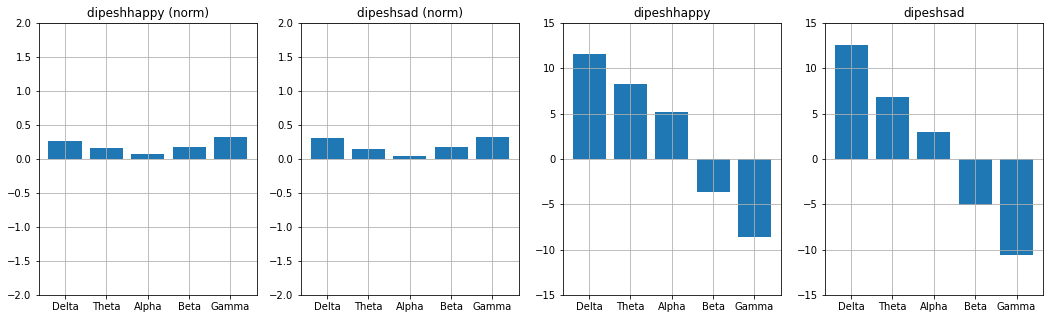

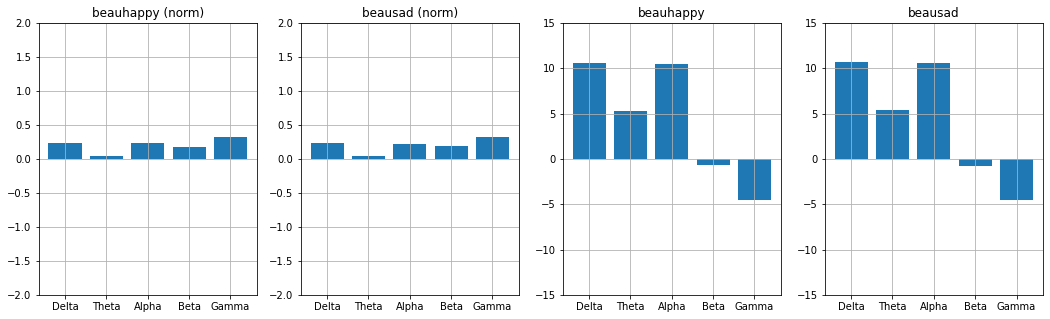

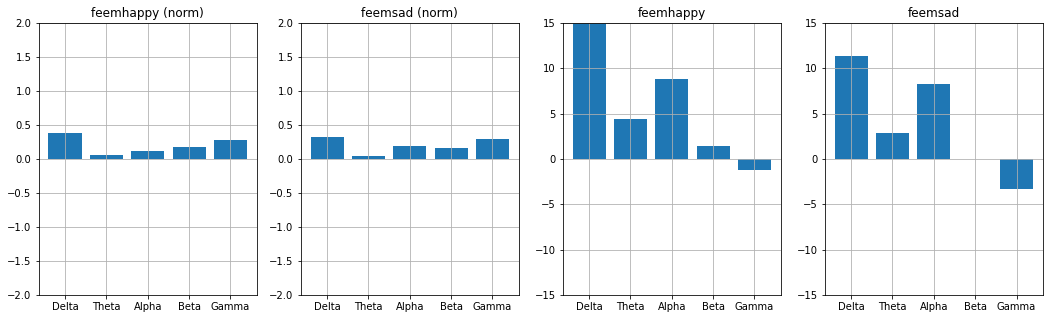

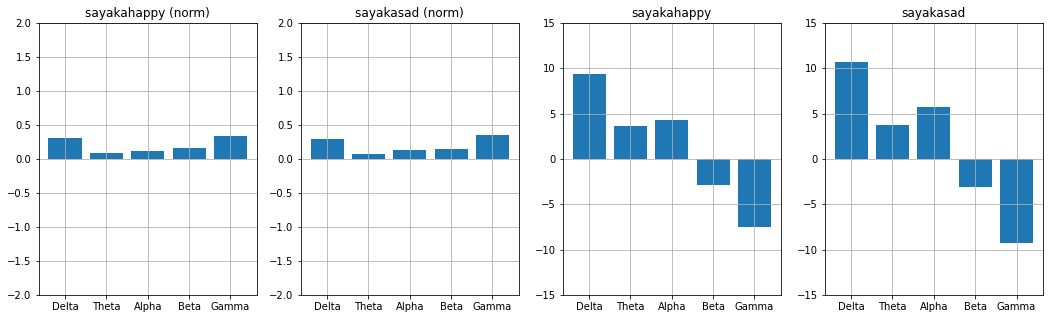

In [ ]:
names = ['dipesh', 'beau','feem', 'sayaka']

for name in names:
    fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
    lim = 2
    X_range = ['Delta','Theta','Alpha','Beta','Gamma']
    
    # happy
    title = f"{name}happy"
    x = X_ratio[name_arr.index(title)]
    ax[0].bar(X_range, x)
    ax[0].set_title(title + " (norm)")
    ax[0].set_ylim(-1*lim,lim)
    ax[0].grid()
    # sad
    title = f"{name}sad"
    x = X_ratio[name_arr.index(title)]
    ax[1].bar(X_range, x)
    ax[1].set_title(title + " (norm)")
    ax[1].set_ylim(-1*lim,lim)
    ax[1].grid()
    # plt.show()

    # X_5
    # happy
    lim = 15
    title = f"{name}happy"
    x = X_5[name_arr.index(title)]
    ax[2].bar(X_range, x)
    ax[2].set_title(title)
    ax[2].set_ylim(-1*lim,lim)
    ax[2].grid()
    # sad
    title = f"{name}sad"
    x = X_5[name_arr.index(title)]
    ax[3].bar(X_range, x)
    ax[3].set_title(title)
    ax[3].set_ylim(-1*lim,lim)
    ax[3].grid()
    plt.show()
    print()

In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_ratio, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.014631032943725586
	Kernel=poly| Acc=0.625 | 3-CV score=0.27778 STD=0.20787| Time spend=0.009213447570800781
	Kernel=rbf| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.013956785202026367
	Kernel=sigmoid| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.00947713851928711


In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_norm, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.0192716121673584
	Kernel=poly| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.009499073028564453
	Kernel=rbf| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.00970768928527832
	Kernel=sigmoid| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.009753227233886719


In [ ]:
print(ch_names)
psds.shape

['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'T3', 'T4', 'T5', 'T6', 'P3', 'P4', 'O1', 'O2']


(8, 16, 63)

In [ ]:
F3_a = psds[:,ch_names.index('F3'),7:14].mean(axis=1).reshape(-1,1)
F4_a = psds[:,ch_names.index('F4'),7:14].mean(axis=1).reshape(-1,1)
a_f = (F4_a - F3_a) / (F4_a + F3_a)
T3_a = psds[:,ch_names.index('T3'),7:14].mean(axis=1).reshape(-1,1)
T4_a = psds[:,ch_names.index('T4'),7:14].mean(axis=1).reshape(-1,1)
a_t = (T4_a - T3_a) / (T4_a + T3_a)
a_a = a_f - a_t
X_asym_alpha = np.hstack([a_f, a_t, a_a])
print(X_asym_alpha.shape)

(8, 3)


In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_asym_alpha, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.021908283233642578
	Kernel=poly| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.01392221450805664
	Kernel=rbf| Acc=0.625 | 3-CV score=0.16667 STD=0.2357| Time spend=0.02499103546142578
	Kernel=sigmoid| Acc=0.5 | 3-CV score=0.38889 STD=0.07857| Time spend=0.01013326644897461


In [ ]:
0.389\pm0.079
0.389\pm0.079
0.167\pm0.236
0.389\pm0.079

In [ ]:
# names = ['dipesh', 'beau','feem', 'sayaka']

# for name in names:
#     fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
#     lim = 2
#     X_range = ['Delta','Theta','Alpha','Beta','Gamma']
    
#     # happy
#     title = f"{name}happy"
#     x = X_asym_alpha[name_arr.index(title)]
#     ax[0].bar([0,1,2], x)
#     ax[0].set_title(title + " (norm)")
#     ax[0].set_ylim(-1*lim,lim)
#     ax[0].grid()
#     # sad
#     title = f"{name}sad"
#     x = X_asym_alpha[name_arr.index(title)]
#     ax[1].bar([0,1,2], x)
#     ax[1].set_title(title + " (norm)")
#     ax[1].set_ylim(-1*lim,lim)
#     ax[1].grid()
#     # plt.show()

#     # X_5
#     # happy
#     lim = 15
#     title = f"{name}happy"
#     x = X_5[name_arr.index(title)]
#     ax[2].bar(X_range, x)
#     ax[2].set_title(title)
#     ax[2].set_ylim(-1*lim,lim)
#     ax[2].grid()
#     # sad
#     title = f"{name}sad"
#     x = X_5[name_arr.index(title)]
#     ax[3].bar(X_range, x)
#     ax[3].set_title(title)
#     ax[3].set_ylim(-1*lim,lim)
#     ax[3].grid()
#     plt.show()
#     print()

In [ ]:
def myScaler(data):
  for index,_ in enumerate(data):
    row = data[index]
    mean = row.mean()
    std = row.std()
    data[index] = (row - mean) / std
  return data

In [ ]:
F3 = myScaler(psds[:,ch_names.index('F3'),:])
F4 = myScaler(psds[:,ch_names.index('F4'),:])
T3 = myScaler(psds[:,ch_names.index('T3'),:])
T4 = myScaler(psds[:,ch_names.index('T4'),:])

F3_a = F3[:,7:14].mean(axis=1).reshape(-1,1)
F4_a = F4[:,7:14].mean(axis=1).reshape(-1,1)
a_f = (F4_a - F3_a) / (F4_a + F3_a)

T3_a = T3[:,7:14].mean(axis=1).reshape(-1,1)
T4_a = T4[:,7:14].mean(axis=1).reshape(-1,1)
a_t = (T4_a - T3_a) / (T4_a + T3_a)
a_a = a_f + a_t
X_asym_alpha_norm = np.hstack([a_f, a_t, a_a])
print(X_asym_alpha_norm.shape)

(8, 3)


In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_asym_alpha_norm, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.0173032283782959
	Kernel=poly| Acc=0.75 | 3-CV score=0.5 STD=0.13608| Time spend=0.020729541778564453
	Kernel=rbf| Acc=0.75 | 3-CV score=0.38889 STD=0.07857| Time spend=0.01287388801574707
	Kernel=sigmoid| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.00977325439453125


In [ ]:
0.389\pm0.079
0.500\pm0.136
0.389\pm0.079
0.389\pm0.079

In [ ]:
# names = ['dipesh', 'beau','feem', 'sayaka']

# for name in names:
#     fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
#     lim = 0.3
#     X_range = ['Delta','Theta','Alpha','Beta','Gamma']
    
#     # happy
#     title = f"{name}happy"
#     x = X_asym_alpha_norm[name_arr.index(title)]
#     ax[0].bar([0,1,2], x)
#     ax[0].set_title(title + " (norm)")
#     ax[0].set_ylim(-1*lim,lim)
#     ax[0].grid()
#     # sad
#     title = f"{name}sad"
#     x = X_asym_alpha_norm[name_arr.index(title)]
#     ax[1].bar([0,1,2], x)
#     ax[1].set_title(title + " (norm)")
#     ax[1].set_ylim(-1*lim,lim)
#     ax[1].grid()
#     # plt.show()

#     # X_5
#     # happy
#     lim = 15
#     title = f"{name}happy"
#     x = X_5[name_arr.index(title)]
#     ax[2].bar(X_range, x)
#     ax[2].set_title(title)
#     ax[2].set_ylim(-1*lim,lim)
#     ax[2].grid()
#     # sad
#     title = f"{name}sad"
#     x = X_5[name_arr.index(title)]
#     ax[3].bar(X_range, x)
#     ax[3].set_title(title)
#     ax[3].set_ylim(-1*lim,lim)
#     ax[3].grid()
#     plt.show()
#     print()

In [ ]:
F3 = myScaler(psds[:,ch_names.index('F3'),:])
F4 = myScaler(psds[:,ch_names.index('F4'),:])
T3 = myScaler(psds[:,ch_names.index('T3'),:])
T4 = myScaler(psds[:,ch_names.index('T4'),:])

F3_b = F3[:,13:31].mean(axis=1).reshape(-1,1)
F4_b = F4[:,13:31].mean(axis=1).reshape(-1,1)
b_f = (F4_b - F3_b) / (F4_b + F3_b)

T3_b = T3[:,13:31].mean(axis=1).reshape(-1,1)
T4_b = T4[:,13:31].mean(axis=1).reshape(-1,1)
b_t = (T4_b - T3_b) / (T4_b + T3_b)
a_b = b_f + b_t
X_asym_beta_norm = np.hstack([b_f, b_t, a_b])
# X_asym_beta_norm = np.hstack([a_b])
print(X_asym_beta_norm.shape)

(8, 3)


In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(X_asym_beta_norm, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.875 | 3-CV score=0.61111 STD=0.07857| Time spend=0.0269167423248291
	Kernel=poly| Acc=0.625 | 3-CV score=0.5 STD=0.13608| Time spend=0.009694099426269531
	Kernel=rbf| Acc=0.875 | 3-CV score=0.5 STD=0.13608| Time spend=0.010144233703613281
	Kernel=sigmoid| Acc=1.0 | 3-CV score=0.88889 STD=0.15713| Time spend=0.009788274765014648


In [ ]:
$0.611\pm0.079$
$0.500\pm0.136$
$0.500\pm0.136$
$0.889\pm0.157$

In [ ]:
# names = ['dipesh', 'beau','feem', 'sayaka']

# for name in names:
#     fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
#     lim = 2
#     X_range = ['Delta','Theta','Alpha','Beta','Gamma']
    
#     # happy
#     title = f"{name}happy"
#     x = X_asym_beta_norm[name_arr.index(title)]
#     ax[0].bar([0,1,2], x)
#     ax[0].set_title(title + " (norm)")
#     ax[0].set_ylim(-1*lim,lim)
#     ax[0].grid()
#     # sad
#     title = f"{name}sad"
#     x = X_asym_beta_norm[name_arr.index(title)]
#     ax[1].bar([0,1,2], x)
#     ax[1].set_title(title + " (norm)")
#     ax[1].set_ylim(-1*lim,lim)
#     ax[1].grid()
#     # plt.show()

#     # X_5
#     # happy
#     lim = 15
#     title = f"{name}happy"
#     x = X_5[name_arr.index(title)]
#     ax[2].bar(X_range, x)
#     ax[2].set_title(title)
#     ax[2].set_ylim(-1*lim,lim)
#     ax[2].grid()
#     # sad
#     title = f"{name}sad"
#     x = X_5[name_arr.index(title)]
#     ax[3].bar(X_range, x)
#     ax[3].set_title(title)
#     ax[3].set_ylim(-1*lim,lim)
#     ax[3].grid()
#     plt.show()
#     print()

In [ ]:
asym = np.hstack([a_f,a_t,a_a,b_f,b_t,a_b])
asym.shape

(8, 6)

In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(asym, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.875 | 3-CV score=0.72222 STD=0.20787| Time spend=0.03739500045776367
	Kernel=poly| Acc=0.625 | 3-CV score=0.5 STD=0.13608| Time spend=0.028079509735107422
	Kernel=rbf| Acc=0.875 | 3-CV score=0.5 STD=0.13608| Time spend=0.017854928970336914
	Kernel=sigmoid| Acc=1.0 | 3-CV score=0.88889 STD=0.15713| Time spend=0.01821756362915039


In [ ]:
$0.722\pm0.208$
$0.500\pm0.136$
$0.500\pm0.136$
$0.889\pm0.157$

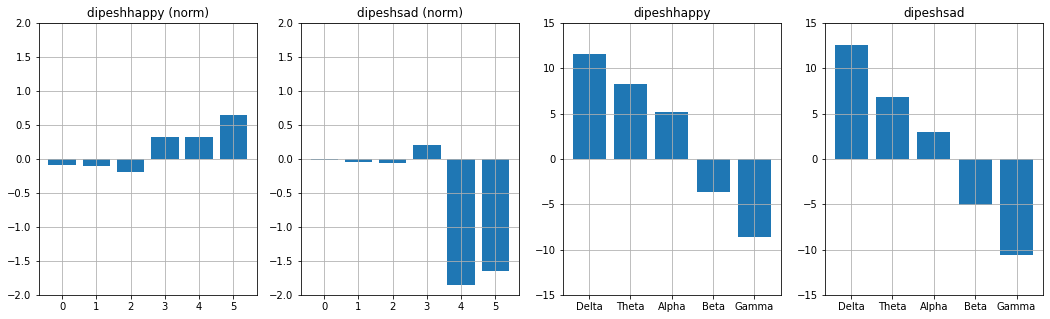

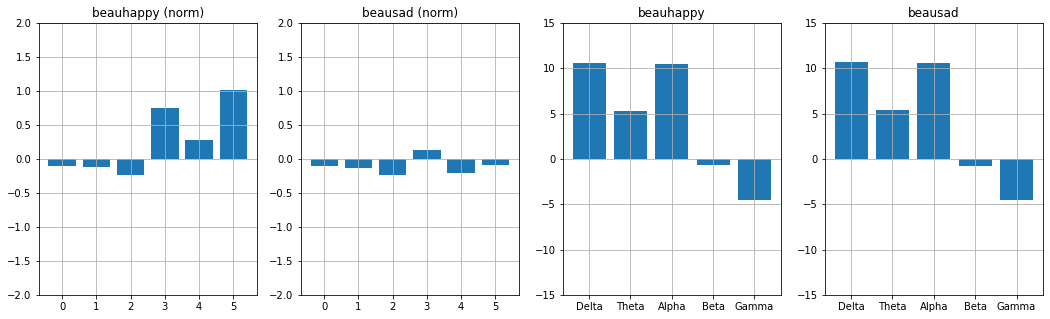

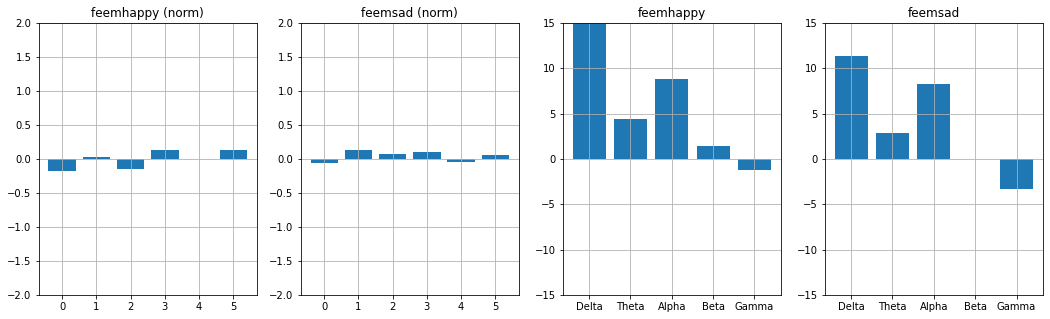

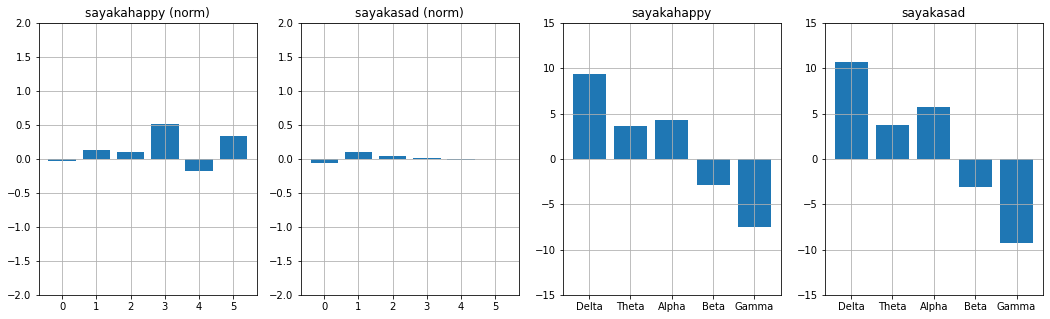

In [ ]:
names = ['dipesh', 'beau','feem', 'sayaka']

for name in names:
    fig,ax = plt.subplots(nrows=1, ncols=4, figsize=(18,5))
    lim = 2
    X_range = ['Delta','Theta','Alpha','Beta','Gamma']
    
    # happy
    title = f"{name}happy"
    x = asym[name_arr.index(title)]
    ax[0].bar([0,1,2,3,4,5], x)
    ax[0].set_title(title + " (norm)")
    ax[0].set_ylim(-1*lim,lim)
    ax[0].grid()
    # sad
    title = f"{name}sad"
    x = asym[name_arr.index(title)]
    ax[1].bar([0,1,2,3,4,5], x)
    ax[1].set_title(title + " (norm)")
    ax[1].set_ylim(-1*lim,lim)
    ax[1].grid()
    # plt.show()

    # X_5
    # happy
    lim = 15
    title = f"{name}happy"
    x = X_5[name_arr.index(title)]
    ax[2].bar(X_range, x)
    ax[2].set_title(title)
    ax[2].set_ylim(-1*lim,lim)
    ax[2].grid()
    # sad
    title = f"{name}sad"
    x = X_5[name_arr.index(title)]
    ax[3].bar(X_range, x)
    ax[3].set_title(title)
    ax[3].set_ylim(-1*lim,lim)
    ax[3].grid()
    plt.show()
    print()

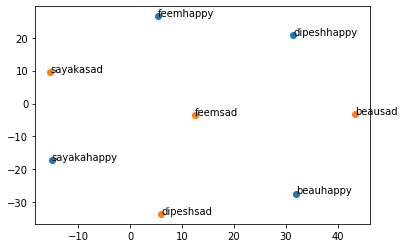

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(asym)
X_embedded.shape

happy = y==0
sad = y==1
plt.scatter(X_embedded[happy,0],X_embedded[happy,1])
plt.scatter(X_embedded[sad,0],X_embedded[sad,1])

for index,name in enumerate(name_arr):
  point = X_embedded[index,:]
  plt.text(point[0],point[1], s=f"{name}")
  # (point[0],point[1], s=f"{name}")

In [ ]:
Fp1 = myScaler(psds[:,ch_names.index('Fp1'),:])
Fp2 = myScaler(psds[:,ch_names.index('Fp2'),:])
F3 = myScaler(psds[:,ch_names.index('F3'),:])
F4 = myScaler(psds[:,ch_names.index('F4'),:])
left = ((Fp1[:,1:62].mean(axis=1) + F3[:,1:62].mean(axis=1)) / 2).reshape(-1,1)
right = ((Fp2[:,1:62].mean(axis=1) + F4[:,1:62].mean(axis=1)) / 2).reshape(-1,1)
lr = np.hstack([left,right, left/right])
lr.shape

(8, 3)

In [ ]:
import time
for kernel in ['linear','poly','rbf', 'sigmoid']:
    start = time.time()
    model, acc, cross = train_model(lr, y, kernel=kernel)
    # We can save the model and reuse it later
    print(f"\tKernel={kernel}| Acc={round(acc,5)} | 3-CV score={round(cross.mean(),5)} STD={round(cross.std(),5)}| Time spend={time.time() - start}")

	Kernel=linear| Acc=0.75 | 3-CV score=0.55556 STD=0.31427| Time spend=0.022131681442260742
	Kernel=poly| Acc=0.75 | 3-CV score=0.61111 STD=0.07857| Time spend=0.010062694549560547
	Kernel=rbf| Acc=0.75 | 3-CV score=0.55556 STD=0.31427| Time spend=0.009575366973876953
	Kernel=sigmoid| Acc=0.625 | 3-CV score=0.38889 STD=0.07857| Time spend=0.009432554244995117


In [ ]:
$0.556\pm0.314$
$0.611\pm0.079$
$0.556\pm0.314$
$0.389\pm0.079$

Matrix
SVM+Kernel -> 3-CV

5 Different Feature Extraction
- X_5: 5 freq bands
- **asym_alpha**: alpha_frontal, alpha_temporal, **alpha_asymmetry**
- asym_beta: beta_frontal, beta_temporal, beta_asymmetry
- **asym**: alpha_frontal, alpha_temporal, **alpha_asymmetry**, beta_frontal, beta_temporal
- LR: left, right, left/right


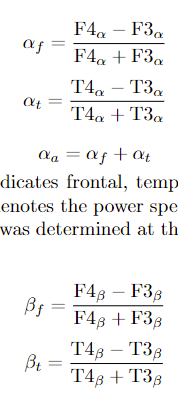